In [1]:
# ANN OCR trained with Noise
# numpy/tensorflow/keras
#
# ICIN/IC Ex1 - Ago/2018 - Adolfo Bauchspiess
#
# Modificado por Luan Haickel Araújo 1/2019

import numpy as np

from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.lines as lines

import tensorflow as tf
 
import geraChar


N=   6# Levels of noise
Nnt= 10# Number of training noise samples for each noise level
Nnv= 500# Number of validating noise samples
NStep=  10# Noise step

P=[]  # Pattern
T=[]  # Target
Pn=[] # Noise Pattern
fitT=np.zeros((N),dtype=int)  # Store the number of incorrect Chars while training
fitV=np.zeros((N),dtype=int)  # Store the number of incorrect Chars while training


Using TensorFlow backend.


In [2]:
# create models with 0, 10, 20 .... 90% noisy bit
(P,T)=geraChar.geraChar()

# Creat a set of N ANNs
Models=[]
for i in range(N): # for each model    
    model = Sequential()
    model.add(Dense(30, activation="sigmoid", kernel_initializer="uniform", input_dim=63))
    model.add(Dense(16, activation="sigmoid", kernel_initializer="uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    Models.append(model)
    
print("Train networks")   
Models[0].fit(P, T, epochs=5, batch_size=1, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Train networks
Instructions for updating:
Use tf.cast instead.


In [3]:

for i in range(1,N): # for each model
# Learn Nstep epochs Noise Chars + epochs reforcing orig. Chars.
                            
    # Mantain Models[i-1] and proceed training with noise
    Models[i].set_weights(Models[i-1].get_weights())
                            
    # test with different noise levels (at least once - range(i+1))
    for k in range(Nnt):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        Models[i].fit(Pn, T, epochs=5, batch_size=1, verbose=0)
        (incorr,idx) = geraChar.validacao(Pn,Models[i])
        fitT[i] += incorr
         
    #Pn = geraChar.gchar_ruido(P,0) # Reforce learning without noise 
    Models[i].fit(P, T, epochs=5, batch_size=1, verbose=0)
    (incorr,idx) = geraChar.validacao(P,Models[i])
    fitT[i] += incorr

    print("Rede i",i,"incorr",str(np.round(fitT[i],2)))
 

Rede i 1 incorr 152
Rede i 2 incorr 27
Rede i 3 incorr 17
Rede i 4 incorr 12
Rede i 5 incorr 23


In [4]:
print(model.summary())
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 30)                1920      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                496       
Total params: 2,416
Trainable params: 2,416
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
# Validate the trained ANN

fitV=np.zeros((N),dtype=float)
for i in range(N): # for each model
    for k in range(Nnv):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        (incorr,idx) = geraChar.validacao(Pn,Models[i])
        fitV[i] += incorr
FitV=np.round(100*fitV/(16*Nnv),2)
print("Test ANN trained with 0%, 10%,...  noise. % incorrect Chars = ",FitV)

fitO=np.zeros((N),dtype=float)
for i in range(N): # for each model
    for k in range(Nnv):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        (incorr,idx) = geraChar.validacao(Pn,Models[0])
        fitO[i] += incorr
FitO=np.round(100*fitO/(16*Nnv),2)
print("Test original (no noisy train) % incorrect Chars = ",FitO)



Test ANN trained with 0%, 10%,...  noise. % incorrect Chars =  [93.75 63.8  26.85 50.12 44.55 46.82]
Test original (no noisy train) % incorrect Chars =  [93.75 93.75 93.75 93.75 93.75 93.75]


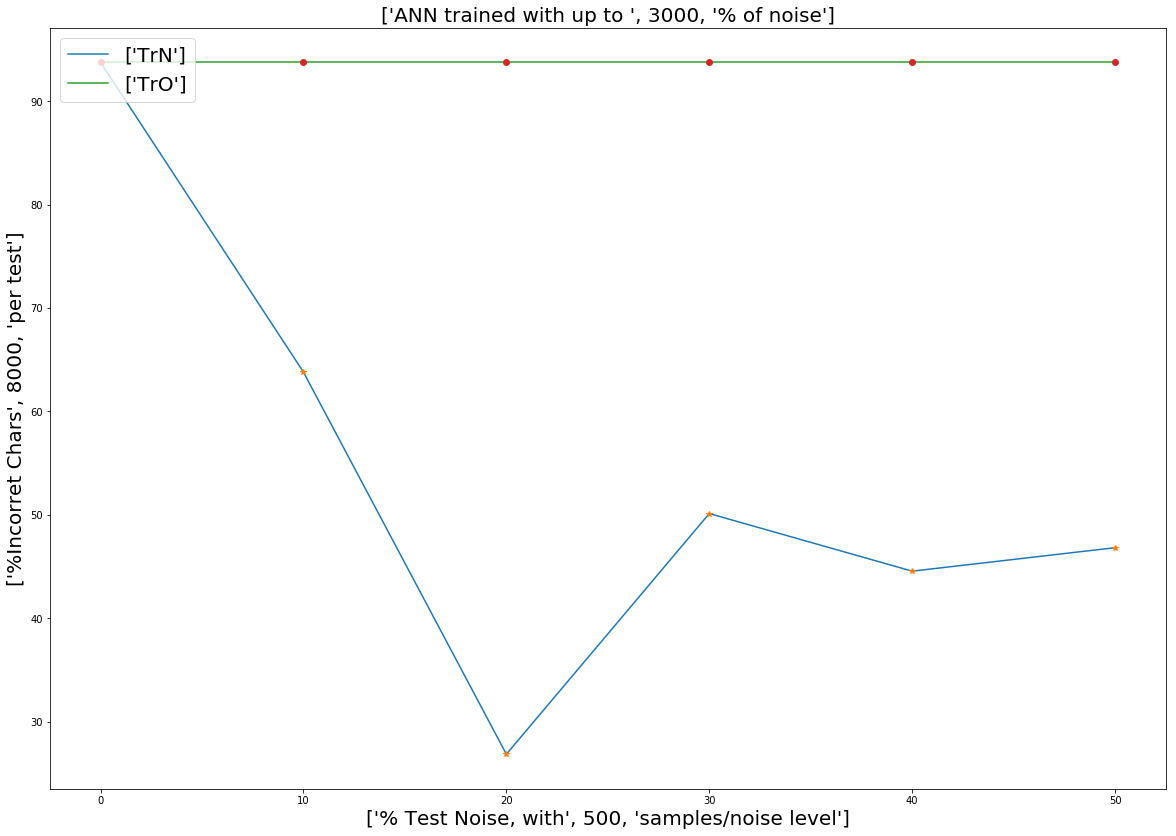

In [6]:
plt.figure(figsize=(20,14))
 
plt.plot(range(0,NStep*N,NStep),FitV, label=['TrN'])
plt.plot(range(0,NStep*N,NStep),FitV,'*')

plt.plot(range(0,NStep*N,NStep),FitO, label=['TrO'])
plt.plot(range(0,NStep*N,NStep),FitO,'o')

plt.title(['ANN trained with up to ' ,N*Nnv,'% of noise'], fontsize=20)
plt.ylabel(["%Incorret Chars",Nnv*16,'per test'], fontsize=20)
plt.xlabel(['% Test Noise, with',Nnv,'samples/noise level'], fontsize=20)
plt.legend(loc='upper left', fontsize=20)
 
plt.savefig('figANN.pdf')
plt.show()     